In [1]:
from IPython.display import display, clear_output
import keyboard
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['cmr10'],
    "axes.labelsize": 22, 
    "axes.titlesize": 22, 
    "xtick.labelsize": 22, 
    "ytick.labelsize": 22, 
    "legend.fontsize": 20,
    "figure.figsize": [12, 7], 
    "figure.dpi": 300 
})
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import NonNeg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import itertools

In [2]:
def t_w (w, k, Omega, DeltaE, gamma, g):
    numerador = -k
    denominador = (Omega-w) - 1j * k - 1j * g**2 / (1j * (DeltaE - w) + gamma)
    t = numerador / denominador
    return abs(t)

Omega = 1

In [3]:
# Definimos una función que genere la base de datos
def Parameters_generator (num_datos):
    k = np.random.uniform(1e-4, 1e-2, num_datos)
    DeltaE = np.random.uniform(0.5, 1.5, num_datos)
    gamma = np.random.uniform(1e-4, 1e-2, num_datos)
    g = np.random.uniform(1e-4, 1e-2, num_datos)

    return k, DeltaE, gamma, g

num_datos = 10000

In [4]:
def Dense_complex(combination):
    model = Sequential()
    model.add(Input(shape=(input_neurons,)))
    
    # Añadir capas ocultas según la combinación especificada
    for num_neurons in combination:
        model.add(Dense(num_neurons, activation='relu'))
    
    model.add(Dense(output_neurons, activation='linear', kernel_constraint=NonNeg()))
    
    # Compilar el modelo
    model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
    
    return model

batch_size = 100
epochs = 1000

# Crear base de datos

In [5]:
# #Creamos base de datos y guardamos en .txt
# k, DeltaE, gamma, g = Parameters_generator (num_datos)
# np.savetxt('Parameters_previous-set.txt', np.column_stack((k, DeltaE, gamma, g))) 

In [6]:
datos = np.loadtxt('Parameters_previous-set.txt')
k = datos[:,0]
DeltaE = datos[:,1]
gamma = datos[:,2]
g = datos[:,3]

#Creamos los valores de y (la función t(w)) con nuestra base de datos
w_values = np.linspace(0.85, 1.15, 300)

# Crear una matriz para almacenar los t(w)
t_values = np.zeros((num_datos, len(w_values)))

# Almacenar los resultados en la matriz 
# (elemento [i,j] fila i es el número de combinación de [k, DeltaE, gamma, g] 
# y la comluna j el elemento de w_values)
for i in range (num_datos):
    t_values[i,:] = t_w(w_values, k[i], Omega, DeltaE[i], gamma[i], g[i])

# Dividir los datos en entrenamiento y validación
x_train, x_post, y_train, y_post = train_test_split(t_values, datos, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_post, y_post, test_size=0.5)

# Normalizamos los datos
scaler_x = RobustScaler()
x_train_norm = scaler_x.fit_transform(x_train)
x_val_norm = scaler_x.transform(x_val)
x_test_norm = scaler_x.transform(x_test)

scaler_y = RobustScaler()
y_train_norm = scaler_y.fit_transform(y_train)
y_val_norm = scaler_y.transform(y_val)
y_test_norm = scaler_y.transform(y_test)

input_neurons = x_train.shape[1]
output_neurons = y_train.shape[1]

# Entrenamiento

In [7]:
# # Número máximo de capas ocultas
# max_hidden_layers = 5

# # Número de neuronas en cada capa oculta
# neurons_per_layer = [16, 32, 64, 128, 256]

# # Generar todas las combinaciones posibles de capas ocultas y neuronas
# all_combinations = []
# for num_layers in range(1, max_hidden_layers + 1):
#     for combination in itertools.product(neurons_per_layer, repeat=num_layers):
#         if list(combination) == sorted(combination, reverse=True) and len(set(combination)) == len(combination):
#             all_combinations.append(combination)

# # Entrenar modelos y registrar los resultados
# losses = []
# training_times = []

# for combination in all_combinations:
#     model = Dense_complex(combination)
    
#     model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
    
#     start_time = time.time()
#     model.fit(x_train_norm, y_train_norm, epochs=epochs, batch_size=batch_size, validation_data=(x_val_norm, y_val_norm)
#               ,verbose=2)
#     end_time = time.time()
#     training_time = end_time - start_time
    
#     # Registrar pérdida y tiempo de entrenamiento
#     scores = model.evaluate(x_test_norm, y_test_norm, verbose=0)
#     final_loss = scores[0]
#     losses.append(final_loss) 
#     training_times.append(training_time)

# # Convertir listas a matrices numpy
# losses = np.array(losses)
# training_times = np.array(training_times)

# # Guardar los resultados en archivos de texto
# np.savetxt('losses_neurons.txt', losses)
# np.savetxt('training_times_neurons.txt', training_times)

# Gráficas

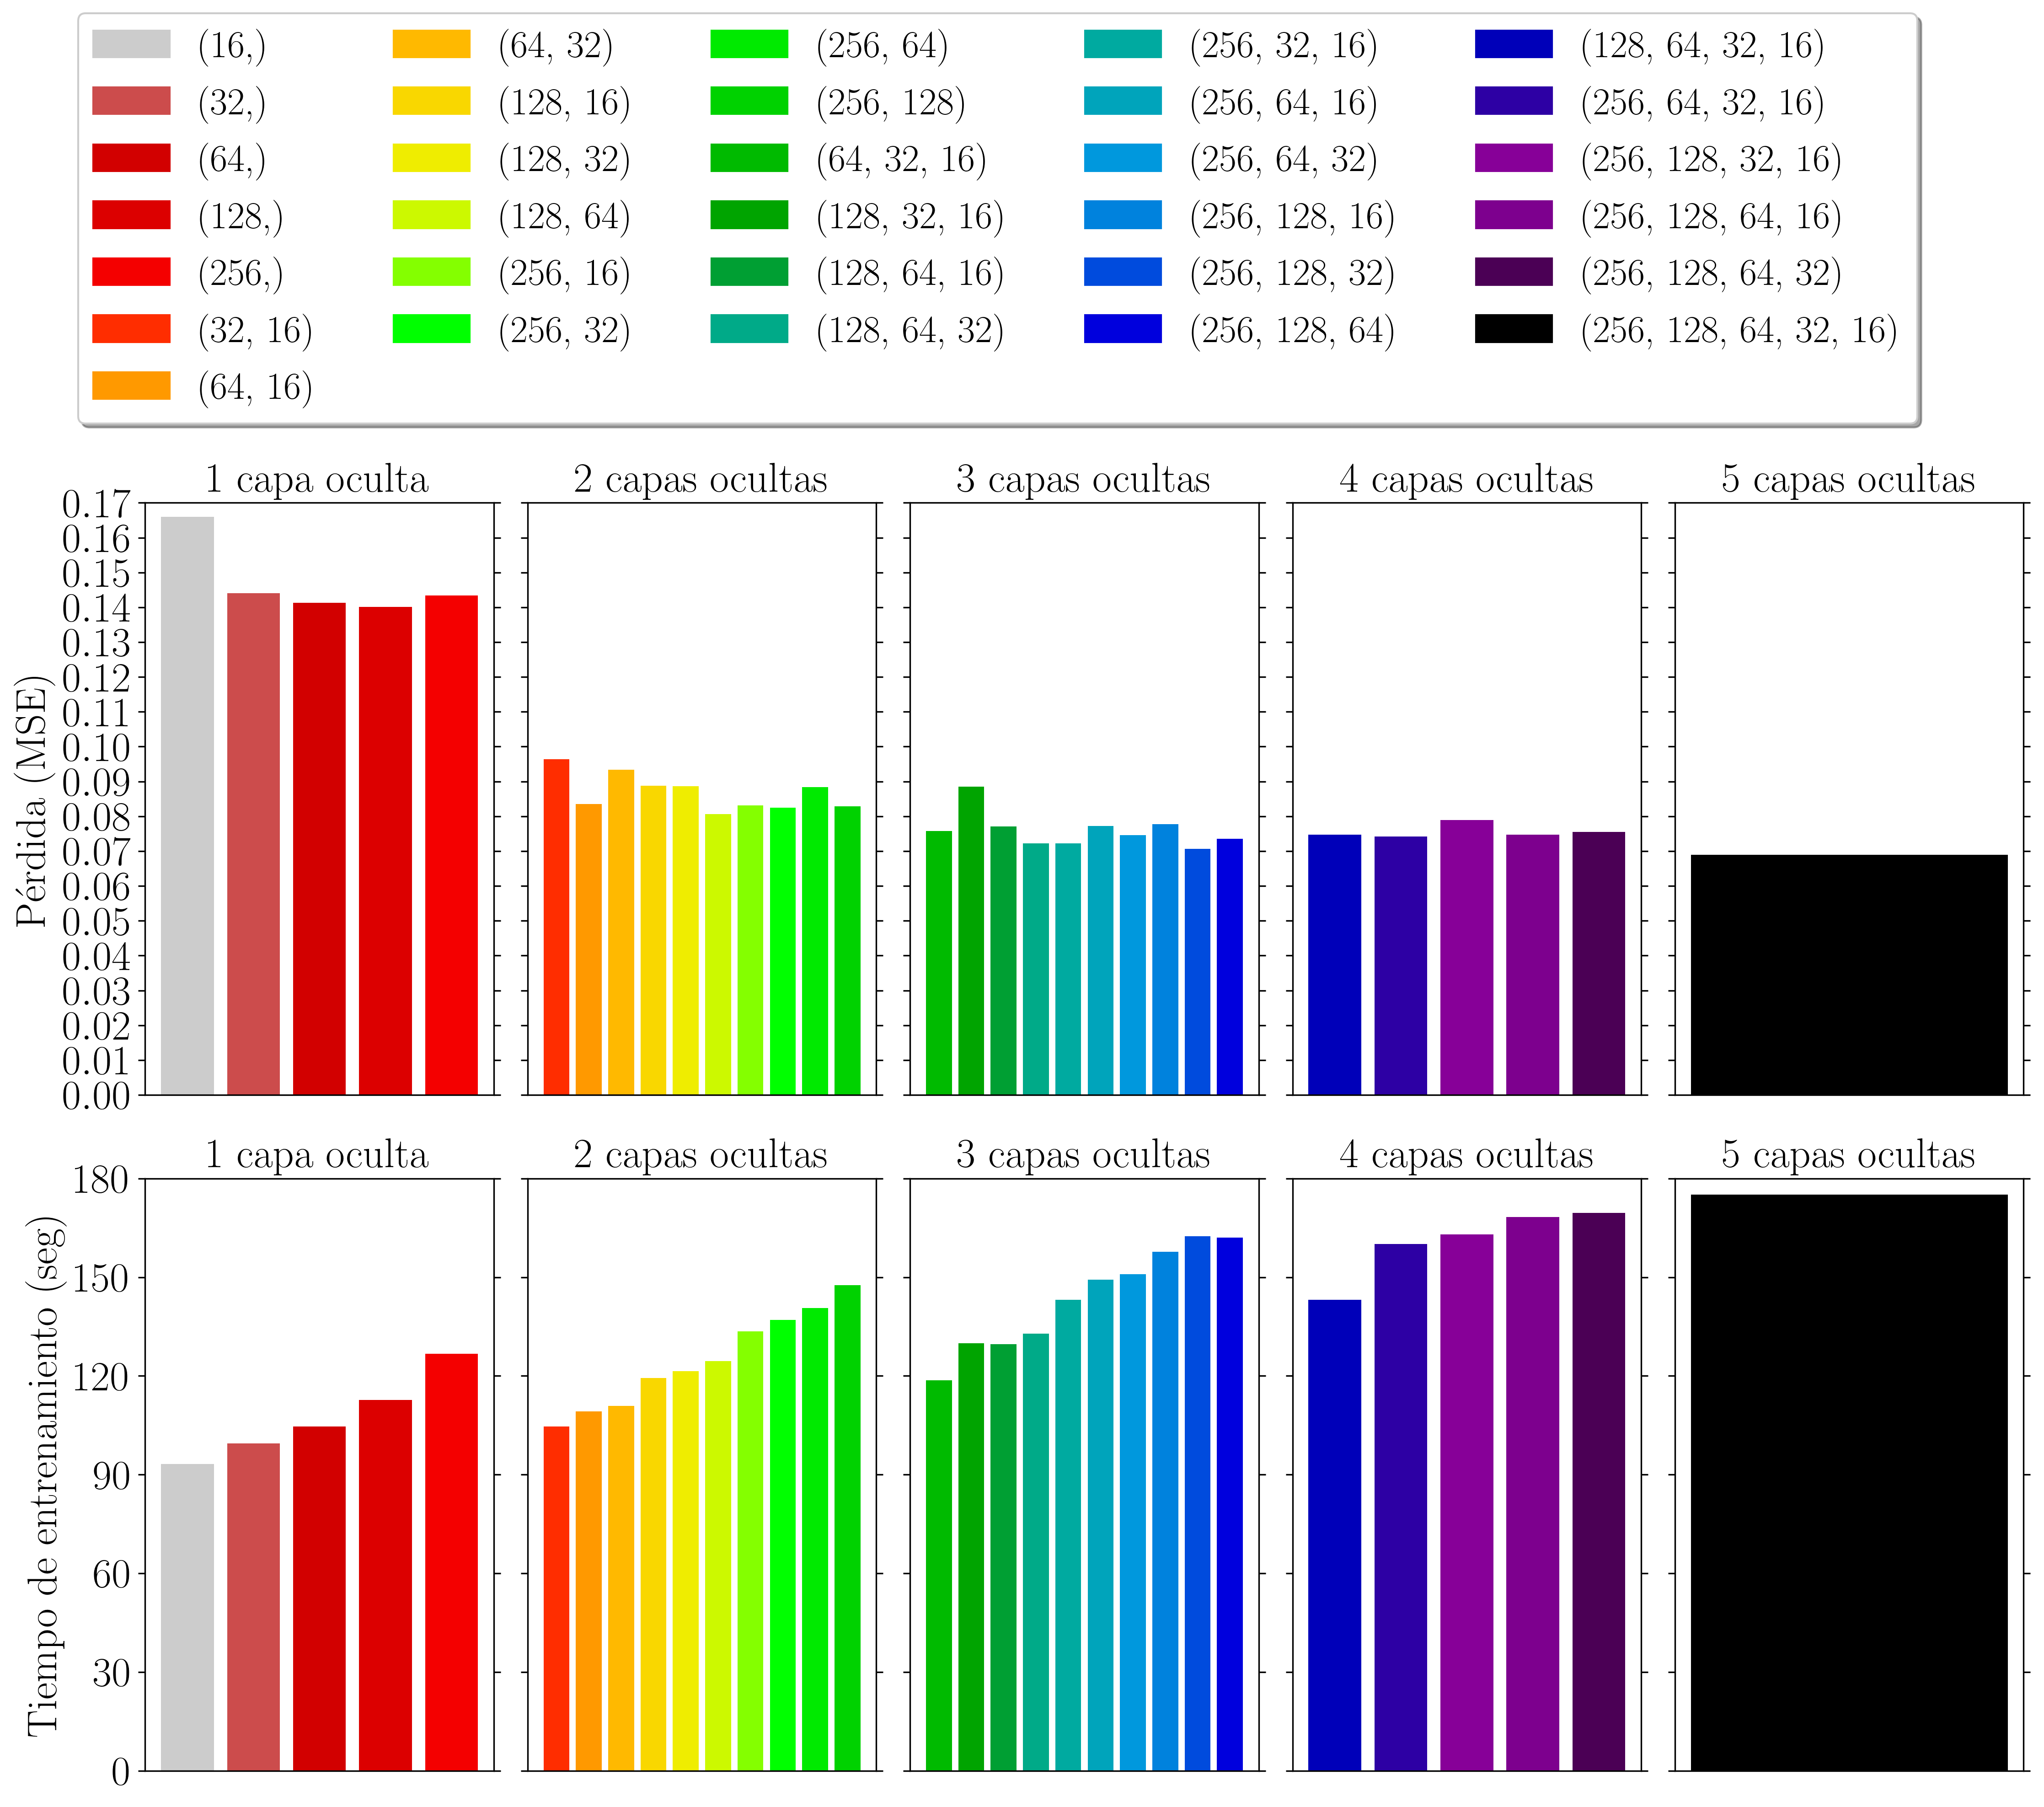

In [10]:
losses = np.loadtxt('losses_neurons.txt')
training_times = np.loadtxt('training_times_neurons.txt')

# Número máximo de capas ocultas
max_hidden_layers = 5

# Número de neuronas en cada capa oculta
neurons_per_layer = [16, 32, 64, 128, 256]

# Generar todas las combinaciones posibles de capas ocultas y neuronas
all_combinations = []
for num_layers in range(1, max_hidden_layers + 1):
    for combination in itertools.product(neurons_per_layer, repeat=num_layers):
        if list(combination) == sorted(combination, reverse=True) and len(set(combination)) == len(combination):
            all_combinations.append(combination)

# Definir una paleta de colores basada en el número de combinaciones
num_colors = len(all_combinations)
color_palette = plt.cm.nipy_spectral_r(np.linspace(0, 1, num_colors))

# Asignar colores únicos a cada combinación
color_dict = {str(combination): color_palette[i] for i, combination in enumerate(all_combinations)}

# Crear figura
plt.figure(figsize=(15, 10))

# Encontrar los valores máximos de los ejes y para todas las subplots
max_loss = np.max(losses)
max_time = np.max(training_times)

# Subplots para pérdidas y tiempos
for i in range(max_hidden_layers):
    # Subplot de pérdidas
    ax = plt.subplot(2, max_hidden_layers, i + 1)
    combinations_layer_i = [comb for comb in all_combinations if len(comb) == i + 1]
    num_combinations = len(combinations_layer_i)
    
    for j, combination in enumerate(combinations_layer_i):
        ax.bar(j + 1, losses[all_combinations.index(combination)], color=color_dict[str(combination)])
        
    ax.set_ylim(0, max_loss)
    ax.set_yticks(np.arange(0, max_loss + 0.01, 0.01))
    ax.yaxis.set_ticks_position('both')
    
    if i == 0:
        ax.set_ylabel('Pérdida (MSE)')
        ax.tick_params(axis='y', labelleft=True, labelright=False)
    else:
        ax.tick_params(axis='y', labelleft=False, labelright=False)
    
    if i + 1 == 1:
        ax.set_title('{} capa oculta'.format(i + 1))
    else:
        ax.set_title('{} capas ocultas'.format(i + 1))
    
    # Subplot de tiempos de entrenamiento
    ax2 = plt.subplot(2, max_hidden_layers, i + 1 + max_hidden_layers)
    for j, combination in enumerate(combinations_layer_i):
        ax2.bar(j + 1, training_times[all_combinations.index(combination)], color=color_dict[str(combination)])
        
    ax2.set_ylim(0, max_time)
    ax2.set_yticks(np.arange(0, max_time + 30, 30))
    ax2.yaxis.set_ticks_position('both')
    
    if i == 0:
        ax2.set_ylabel('Tiempo de entrenamiento (sec)')
        ax2.tick_params(axis='y', labelleft=True, labelright=False)
    else:
        ax2.tick_params(axis='y', labelleft=False, labelright=False)
    
    if i + 1 == 1:
        ax2.set_title('{} capa oculta'.format(i + 1))
    else:
        ax2.set_title('{} capas ocultas'.format(i + 1))

    # Quitar ticks y etiquetas del eje x
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax2.set_xticks([])
    ax2.set_xticklabels([])

# Ajustar el espacio entre subgráficos y los márgenes de la figura
plt.tight_layout()

# Añadir leyenda de colores fuera de la figura, arriba y centrada
legend_elements = [plt.Rectangle((0,0),1,1,color=color_palette[i], label=str(all_combinations[i])) 
                   for i in range(num_colors)]
plt.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.75, 3), fancybox=True, shadow=True, ncol=5)

plt.show()